In [1]:
import numpy as np
from numpy import linalg as LA
from glob import glob
from PIL import Image
from random import randrange
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## We read All images to train list and select 16 of therm for test and delete from train list.
train_list = []
test_list = []
counter = 0

for fname in glob("data/yalefaces/*"):
    im = Image.open(fname)
    im = np.asarray(im.convert("L"))
    train_list.append(im)
    counter += 1

## Randomly select 16 image for Test data Set , and delete them from train image list. M = 320 * 243 = 77760
for i in range(16):
    random_index = randrange(len(train_list))
    test_list.append(train_list.pop(random_index))

## Reshape each image to M*1 matix and save it to S_train list
s_train_list = []
for i in range(len(train_list)):
    fi = train_list[i].reshape((77760,1))
    s_train_list.append(fi)

## Calculate images mean
f_mean = np.zeros((77760,1))
for i in range(len(s_train_list)):
    f_mean = f_mean + s_train_list[i]
f_mean = (1/len(s_train_list)) * f_mean


# Substract mean of images from each of them and saves in A matrix columns.
A = np.zeros((77760,1))
for i in range(len(s_train_list)):
    ai = s_train_list[i] - f_mean
    A = np.hstack((A, ai))

A = A[:,1:]

rank = LA.matrix_rank(A)

U, S , Vh = np.linalg.svd(A, full_matrices=False)


In [2]:
## Reshape each test image to M*1 matix and save it to S_test list
s_test_list = []
for i in range(len(test_list)):
    fi = test_list[i].reshape((77760,1))
    s_test_list.append(fi)
    
# Substract mean of train images from each of test images and saves in diffed_test_list
diffed_test_list = []
for i in range(len(s_test_list)):
    di = s_test_list[i] - f_mean
    diffed_test_list.append(di)


In [3]:
Ut = U.transpose()

## U.T times Substracted Train images ans store in X
X = []
for i in range(A.shape[1]):
    xi = Ut @ A[:,i].reshape((77760,1))
    X.append(xi)
    
## U.T times Substracted Test images and store in Z
Z = []
for i in range(len(diffed_test_list)):
    zi = Ut @ diffed_test_list[i]
    Z.append(zi)

Minimum_Dists = []
for p in range(len(Z)):
    distlist = []
    for t in range(len(X)):
        distlist.append(LA.norm(Z[p] - X[t]))
    Minimum_Dists.append(min(distlist))


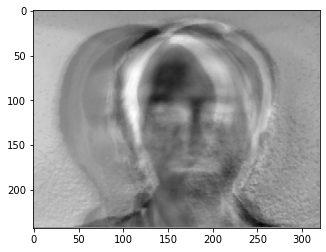

In [4]:
## save mean image 
img = Image.fromarray(f_mean.reshape((243,320)))
img.save("svdrec/meanoftrain.gif")

for i in range(10):
    plt.imshow(U[:,i].reshape((243,320)), cmap="gray")
    plt.savefig("svdrec/UColumns(EigenFace "+str(i)+" )")

Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Unknown Face
Error = 100.0 %


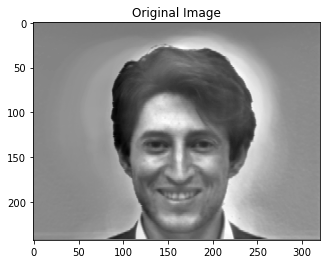

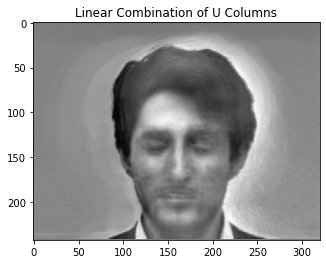

In [5]:
u_c = 0
for s in Minimum_Dists : 
    if s < 675:
        print("Known Face")
    else:
        print("Unknown Face")
        u_c += 1
print ("Error =", u_c*100/len(Z),"%")

## Linear Combination Cofficent of test images in Eigen Space (U Columns)
feature_list=[]
for i in range(len(diffed_test_list)):
    p = diffed_test_list[i]
    feature = []
    for j in range(U.shape[1]):
        q = U[:,j].reshape((77760,1))
        Coff = float(q.T @ p)
        feature.append(Coff)
    feature_list.append(feature)

## showing linear combination of U constract a test image
SAMPLE_NUMBER = 8
p = np.zeros((77760,1))
for i in range(len(feature_list[SAMPLE_NUMBER])):
    p = p + ( feature_list[SAMPLE_NUMBER][i] * U[:,i].reshape((77760,1)) )

plt.imshow(diffed_test_list[SAMPLE_NUMBER].reshape((243,320)), cmap="gray")
plt.title("Original Image")
plt.show()

plt.imshow(p.reshape((243,320)), cmap="gray")
plt.title("Linear Combination of U Columns")
plt.show()



In [6]:
## Decompose and MSE Error
r_Val = [50,75,100,120,140]
MSEs=[]
for i in range(len(r_Val)):
    r = r_Val[i]
    
    Up = np.copy(U) # U'
    Sp = np.copy(S) # S'
    Vhp = np.copy(Vh) # Vh'
    
    # delete U columns 
    while(Up.shape[1] > r):
        Up = np.delete(Up, Up.shape[1] - 1 , 1)
        
    # delete V Rows
    while(Vhp.shape[0] > r):
        Vhp = np.delete(Vhp, Vhp.shape[0] -1 , 0)
    #reduse sigma
    while(len(Sp) > r):
        Sp = np.delete(Sp, len(Sp) - 1, None)
    
    B = Up @ np.diag(Sp) @ Vhp
    
    MSEs.append(mean_squared_error(A,B))
    print("Mse of r = ",r," Calculated.")

Mse of r =  50  Calculated.
Mse of r =  75  Calculated.
Mse of r =  100  Calculated.
Mse of r =  120  Calculated.
Mse of r =  140  Calculated.


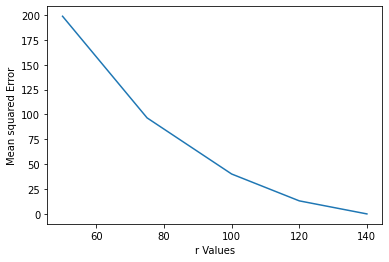

In [7]:
plt.plot(r_Val,MSEs)
plt.ylabel('Mean squared Error')
plt.xlabel('r Values')
plt.show()